# d3viz: Interactive visualization of Theano compute graphs 

## Requirements

``d3viz`` requires the [pydot](https://pypi.python.org/pypi/pydot)
package. [pydot-ng](https://github.com/pydot/pydot-ng) fork is better
maintained, and it works both in Python 2.x and 3.x. Install it with pip::

In [ ]:
!pip install pydot-ng

Like Theano’s [printing module](http://deeplearning.net/software/theano/library/printing.html), ``d3viz``
requires [graphviz](http://www.graphviz.org) binary to be available.

## Overview 

`d3viz` extends Theano’s [printing module](http://deeplearning.net/software/theano/library/printing.html) to interactively visualize compute graphs. Instead of creating a static picture, it creates an HTML file, which can be opened with current web-browsers. `d3viz` allows

* to zoom to different regions and to move graphs via drag and drop,
* to position nodes both manually and automatically,
* to retrieve additional information about nodes and edges such as their data type or definition in the source code,
* to edit node labels,
* to visualizing profiling information, and
* to explore nested graphs such as OpFromGraph nodes.

In [2]:
import theano as th
import theano.tensor as T
import numpy as np

As an example, consider the following multilayer perceptron with one hidden layer and a softmax output layer. 

In [3]:
ninputs = 1000
nfeatures = 100
noutputs = 10
nhiddens = 50

rng = np.random.RandomState(0)
x = T.dmatrix('x')
wh = th.shared(rng.normal(0, 1, (nfeatures, nhiddens)), borrow=True)
bh = th.shared(np.zeros(nhiddens), borrow=True)
h = T.nnet.sigmoid(T.dot(x, wh) + bh)

wy = th.shared(rng.normal(0, 1, (nhiddens, noutputs)))
by = th.shared(np.zeros(noutputs), borrow=True)
y = T.nnet.softmax(T.dot(h, wy) + by)

predict = th.function([x], y)

The function `predict` outputs the probability of 10 classes. You can visualize it with `pydotprint` as follows:

In [4]:
from theano.printing import pydotprint
import os

if not os.path.exists('examples'):
    os.makedirs('examples')
pydotprint(predict, 'examples/mlp.png')

The output file is available at examples/mlp.png


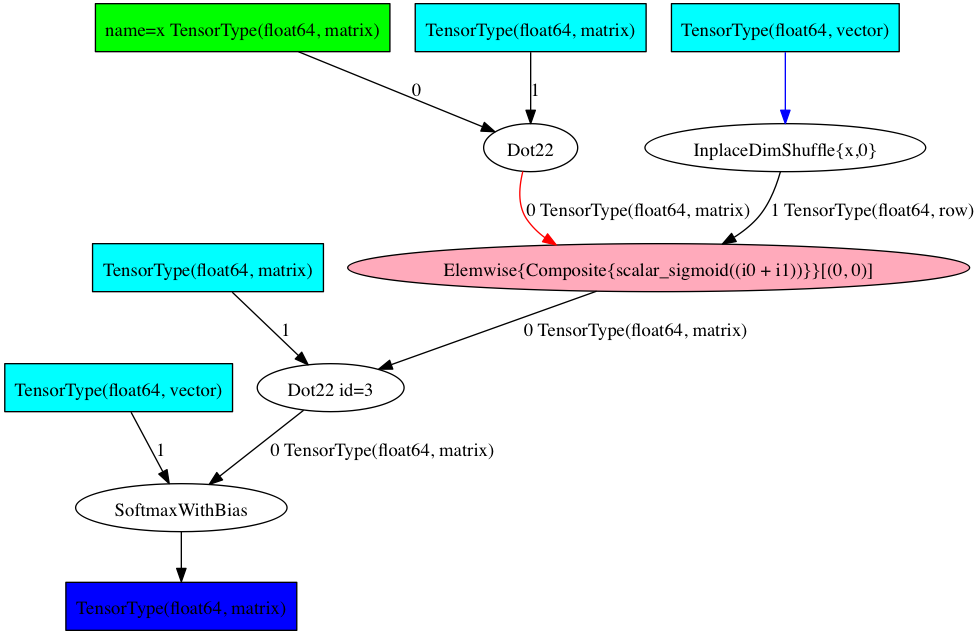

In [5]:
from IPython.display import Image
Image('examples/mlp.png', width='80%')

To visualize it interactively, import the `d3viz` function from the `d3viz` module, which can be called as before:

In [6]:
import theano.d3viz as d3v
d3v.d3viz(predict, 'examples/mlp.html')

[Open visualization!](examples/mlp.html)

When you open the output file `mlp.html` in your web-browser, you will see an interactive visualization of the compute graph. You can move the whole graph or single nodes via drag and drop, and zoom via the mouse wheel. When you move the mouse cursor over a node, a window will pop up that displays detailed information about the node, such as its data type or definition in the source code. When you left-click on a node and select `Edit`, you can change the predefined node label. If you are dealing with a complex graph with many nodes, the default node layout may not be perfect. In this case, you can press the `Release node` button in the top-left corner to automatically arrange nodes. To reset nodes to their default position, press the `Reset nodes` button.

You can also display the interactive graph inline in
IPython using ``IPython.display.IFrame``:

In [8]:
from IPython.display import IFrame
d3v.d3viz(predict, 'examples/mlp.html')
IFrame('examples/mlp.html', width=700, height=500)

Currently if you use display.IFrame you still have to create a file,
and this file can't be outside notebooks root (e.g. usually it can't be
in /tmp/).

## Profiling 

Theano allows [function profiling](http://deeplearning.net/software/theano/tutorial/profiling.html) via the `profile=True` flag. After at least one function call, the compute time of each node can be printed in text form with `debugprint`. However, analyzing complex graphs in this way can be cumbersome.

`d3viz` can visualize the same timing information graphically, and hence help to spot bottlenecks in the compute graph more easily! To begin with, we will redefine the `predict` function, this time by using `profile=True` flag. Afterwards, we capture the runtime on random data:

In [9]:
predict_profiled = th.function([x], y, profile=True)

x_val = rng.normal(0, 1, (ninputs, nfeatures))
y_val = predict_profiled(x_val)

In [10]:
d3v.d3viz(predict_profiled, 'examples/mlp2.html')

[Open visualization!](./examples/mlp2.html)

When you open the HTML file in your browser, you will find an additional `Toggle profile colors` button in the menu bar. By clicking on it, nodes will be colored by their compute time, where red corresponds to a high compute time. You can read out the exact timing information of a node by moving the cursor over it.

## Different output formats

Internally, `d3viz` represents a compute graph in the [Graphviz DOT language](http://www.graphviz.org/), using the [pydot](https://pypi.python.org/pypi/pydot) package, and defines a front-end based on the [d3.js](http://d3js.org/) library to visualize it. However, any other Graphviz front-end can be used, which allows to export graphs to different formats. 

In [11]:
formatter = d3v.formatting.PyDotFormatter()
pydot_graph = formatter(predict_profiled)

pydot_graph.write_png('examples/mlp2.png');
pydot_graph.write_pdf('examples/mlp2.pdf');

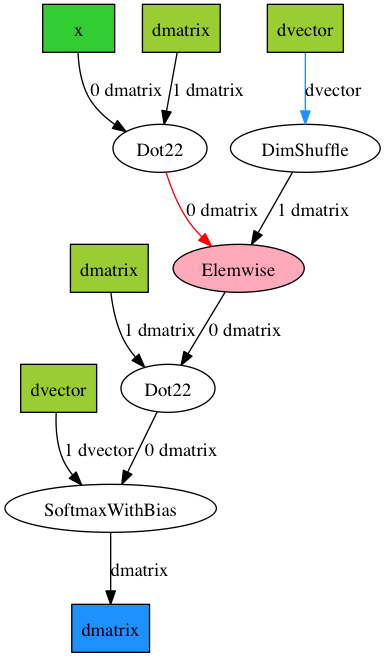

In [12]:
Image('./examples/mlp2.png')

Here, we used the `PyDotFormatter` class to convert the compute graph into a `pydot` graph, and created a [PNG](./examples/mlp2.png) and [PDF](./examples/mlp2.pdf) file. You can find all output formats supported by Graphviz [here](http://www.graphviz.org/doc/info/output.html).

## OpFromGraph nodes 

An [OpFromGraph](http://deeplearning.net/software/theano/library/compile/opfromgraph.html) node defines a new operation, which can be called with different inputs at different places in the compute graph. Each `OpFromGraph` node defines a nested graph, which will be visualized accordingly by `d3viz`.

In [13]:
x, y, z = T.scalars('xyz')
e = T.nnet.sigmoid((x + y + z)**2)
op = th.OpFromGraph([x, y, z], [e])

e2 = op(x, y, z) + op(z, y, x)
f = th.function([x, y, z], e2)

In [14]:
d3v.d3viz(f, 'examples/ofg.html')

[Open visualization!](./examples/ofg.html)

In this example, an operation with three inputs is defined, which is used to build a function that calls this operations twice, each time with different input arguments. 

In the `d3viz` visualization, you will find two OpFromGraph nodes, which correspond to the two OpFromGraph calls. When you double click on one of them, the nested graph appears with the correct mapping of its input arguments. You can move it around by drag and drop in the shaded area, and close it again by double-click.

An OpFromGraph operation can be composed of further OpFromGraph operations, which will be visualized as nested graphs as you can see in the following example.

In [15]:
x, y, z = T.scalars('xyz')
e = x * y
op = th.OpFromGraph([x, y], [e])
e2 = op(x, y) + z
op2 = th.OpFromGraph([x, y, z], [e2])
e3 = op2(x, y, z) + z
f = th.function([x, y, z], [e3])

In [16]:
d3v.d3viz(f, 'examples/ofg2.html')

[Open visualization!](./examples/ofg2.html)

## Feedback 

If you have any problems or great ideas on how to improve `d3viz`, please let me know!

* Christof Angermueller
* <cangermueller@gmail.com>
* https://cangermueller.com